### Import all necessary files

In [1]:
import matplotlib.pyplot as plt

from tweets import *

### 0 Read earlier computed data

In [11]:
# Read choosen dataset and go straight to -> 4 Results <-
dataset = ['dbscan_11x50.data', 'tidbscan_11x50.data', 'tidbscan_11xall.data']
test_method = False

d = read_computed_data(dataset[0])
tweets, class_vector, tweet_vector, results, epsilon_start, epsilon_end, n, distances = d

### 1 Get vectors from table of tweets

In [3]:
# DBSCAN set True, TIDBSCAN set False
test_method = False
# tweets = read_all_tweets(DATA)
tweets, class_vector = read_n_tweets_from_data(DATA, 50) # Provide number of tweets per account
tweet_vector = np.array(get_vectors(tweets))

### 2 Find out epsilon
Find out epsilon by looking at distribution of max, min, median euclidean distances between all points.

In [4]:
%%time
distances = None
# distances = create_and_save_distances_list(tweet_vector, save=False) # Compute distances
# # distances = read_distances_list() # Read previously computed distances
# minimum, median, maximum = get_basic_statistics(distances)
# plot_basic_statistics(minimum, median, maximum)

CPU times: user 0 ns, sys: 12 µs, total: 12 µs
Wall time: 22.6 µs


### 3 Group vectors for multiple epsilon
Now after analyzing distribution of distances between points
do clustering n times for epsilon_start and delta_epsilon parameters

In [5]:
%%time
n = 15
epsilon_start = 0.65
epsilon_end = 1.2

if test_method:
    results = get_results_for_multiple_eps_not_our_implementation(tweet_vector, epsilon_start, epsilon_end, n)
else:
    results = get_results_for_multiple_eps(tweet_vector, epsilon_start, epsilon_end, n)

CPU times: user 24min 3s, sys: 71.8 ms, total: 24min 3s
Wall time: 24min 8s


### 4 Results

Create dataframe from results to visualise it


In [12]:
%%time
if test_method:
    df = get_df_for_test_results(results, class_vector, epsilon_start, epsilon_end, n)
else:
    df = get_df_for_results(results, class_vector, epsilon_start, epsilon_end, n)

CPU times: user 638 ms, sys: 0 ns, total: 638 ms
Wall time: 649 ms


### Visualisation
Plot all clusture for diffrent sigma

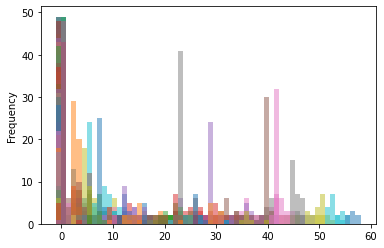

CPU times: user 18.7 s, sys: 125 ms, total: 18.9 s
Wall time: 19 s


In [13]:
%%time
ax = df.plot.hist(bins=60, alpha=0.5, legend=False)
ax.plot()
plt.show()

In [14]:
%%time
#a = df.hist(bins=60, alpha=1, legend=False, figsize=(60,n*4), layout=(n,11))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


### Clustering evaluation


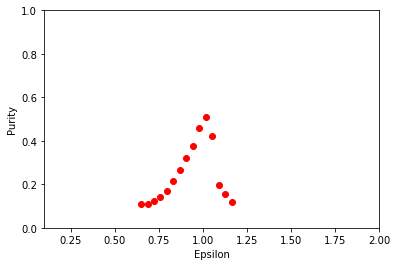

Max purity score is P=0.512, for epsilon=1.0166666666666666. 


In [15]:
if test_method:
    sc = get_purity_for_n_results_dbscan(class_vector, results, len(results))
else:
    sc = get_purity_for_n_results_tidbscan(class_vector, results, len(results))

epsilons = get_epsilon_array(epsilon_start, epsilon_end, n)


plt.plot(epsilons, sc, 'ro')
plt.axis([0.1, 2, 0, 1])
plt.xlabel("Epsilon")
plt.ylabel("Purity")
plt.show()

max_purity=max(sc)
eps_for_max_purity=epsilons[sc.index(max_purity)]
print("Max purity score is P={}, for epsilon={}. ".format(round(max_purity,3), eps_for_max_purity))

In [16]:
gr = get_all_groups_in_result(results, sc.index(max_purity), tweets)
[group_id,number_of_points,indexes_of_points,list_of_tweets, stats,  points] = gr

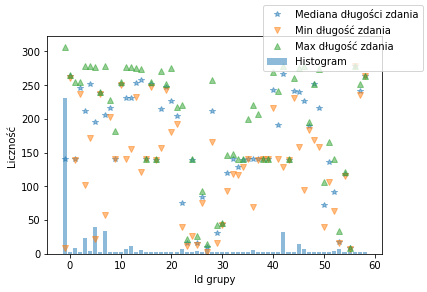

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(group_id, stats["med_sent_length"],'*', alpha=0.5)
ax.bar(group_id, number_of_points, alpha=0.5)
ax.plot(group_id, stats["min_sent_length"],'v', alpha=0.5)
ax.plot(group_id, stats["max_sent_length"],'^', alpha=0.5)
ax.set_xlabel("Id grupy")
ax.set_ylabel("Liczność")
fig.legend(["Mediana długości zdania", "Min długość zdania","Max długość zdania","Histogram"])
fig.savefig('filename.png', dpi=900)
plt.show()

9


In [35]:
for num in range(len(list_of_tweets)):
    print('\033[1m' + "Here is list of {} tweets for group_nr={}".format(len(list_of_tweets[num])-1,num)+'\033[0m')
    a = [print(tw + "\n") for tw in list_of_tweets[num]]
    print("\n\n\n")

Here is list of 230 tweets for group_nr=0
It was because of them I was able to travel to New York City later that week and tell some of the people who had a loved one murdered by al Qaeda on September 11: America has never forgotten your loss. Watch my full conversation with Bill:

Bernie Wong was a trailblazer who spent her life advocating for Asian Americans and immigrant communities in Chicago and across the U.S. Her legacy of community leadership inspired me and so many others, and her impact will be felt for generations to come.

The world’s attention must remain on Myanmar, where I’ve been appalled by heartbreaking violence against civilians and inspired by the nationwide movement that represents the voice of the people.

I love wandering into independent bookstores and discovering new voices and new authors. So on Independent Bookstore Day, I wanted to talk with some of the folks who help support authors and nourish our communities.

With all the enormous challenges facing the w

Here is list of 2 tweets for group_nr=3
States have just learned how many seats they have in Congress for the next decade. This process is an important step in making sure our maps—and electoral process—better reflect our communities. Get involved in the fight for fair maps with @AllOnTheLine:

Let’s be clear: This is a deliberate attempt to undermine our democracy by making it harder to vote. That’s why passing the For the People Act is so important, and why every one of us needs to keep up the fight. Our future depends on it.

